In [45]:
### READING THE DATASET

import pandas as pd
import os as os
import numpy as np
# Creating empty list for broken tooth and healthy gearbox datasets
broken = []
healthy = []

# Defining the path where the datasets are stored
pth1 = 'dataset/BrokenTooth'
pth2 = 'dataset/Healthy'

# Reading the dataset as the list items using the OS library to access the files and read_csv function from pandas to read the daatasets 
# **Reading each file in the BrokenTooth and Healthy directories and appending it to the respective lists as pandas' DataFrame object (abbr.: df)
for file_name in sorted(os.listdir(pth1)):
    this_df = pd.read_csv(os.path.join(pth1, file_name))
    this_df['load'] = 10*int(file_name[5])
    this_df['gearbox_status'] = 0
    broken.append(this_df)

for file_name in sorted(os.listdir(pth2)):
    this_df = pd.read_csv(os.path.join(pth2, file_name))
    this_df['load'] = 10*int(file_name[5])
    this_df['gearbox_status'] = 1
    healthy.append(this_df)

print(broken[0].head())
print(healthy[0].head())

         a1        a2        a3        a4  load  gearbox_status
0  2.350390  1.454870 -1.667080 -2.055610     0               0
1  2.452970  1.400100 -2.825100  0.984487     0               0
2 -0.241284 -0.267390  0.793540  0.605862     0               0
3  1.130270 -0.890918  0.696969  0.613068     0               0
4 -1.296140  0.980479 -1.130560 -0.346971     0               0
         a1        a2        a3       a4  load  gearbox_status
0  4.636710  0.516978 -3.205940  1.82241     0               1
1  1.992800  4.184660 -2.740610  2.80436     0               1
2 -3.764110  0.997335 -1.303090  1.83668     0               1
3 -4.558710  6.104330 -1.720690  1.72311     0               1
4  0.575382  0.170980 -0.497967 -1.32895     0               1


In [43]:
### DATA CLEANING

for i in range(1,10):
    broken[i].isnull().sum()
    healthy[i].isnull().sum()

print(broken[0].isnull().sum())

a1                0
a2                0
a3                0
a4                0
load              0
gearbox_status    0
dtype: int64


In [22]:
### DATA GROUPING

import math

def divide_into(df, n):
    group_size = n
    df_groups = []
    for i in range(math.ceil(df['a1'].count()/group_size)):
        new_df = df.iloc[i*group_size:(i+1)*group_size, :]
        df_groups.append(new_df)
    return df_groups

def get_group_stdevs(df, n):
    groups = divide_into(df, n)
    stdevs = pd.DataFrame(map(pd.DataFrame.std, groups))
    stdevs['load'] = df['load']
    stdevs['gearbox_status'] = df['gearbox_status']
    
    return stdevs

broken_stdev = []
for i in range(0,10):
    broken_stdev.append(get_group_stdevs(broken[i], 100))

healthy_stdev = []
for i in range(0,10):
    healthy_stdev.append(get_group_stdevs(healthy[i], 100))

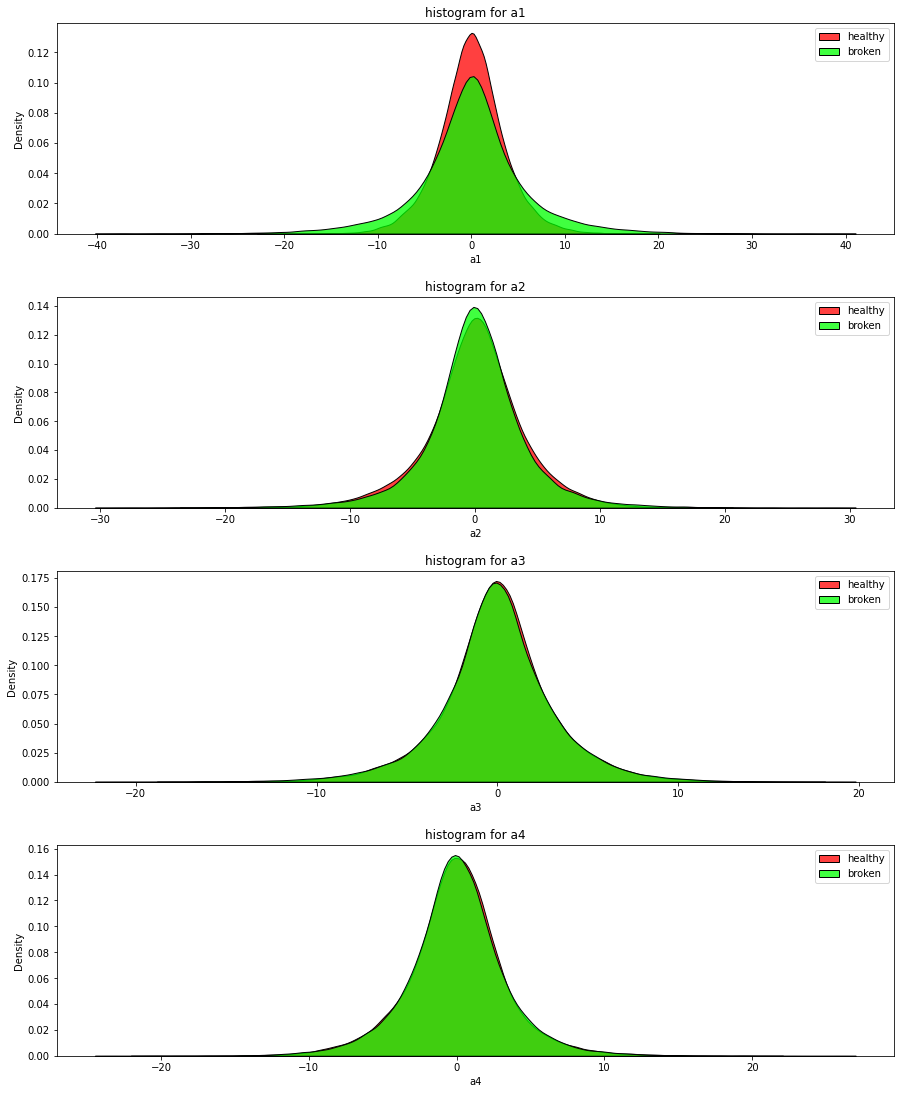

In [23]:
### DATA VISUALISATION

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

load = 0

plt.figure(figsize=(15,28*5))
plt.subplots_adjust(hspace = 0.3)
gs = gridspec.GridSpec(28, 1)
for i, col in enumerate(['a1','a2','a3','a4']):
    ax = plt.subplot(gs[i])
    sns.kdeplot(data = broken[load][col], color = "red", multiple="stack")
    sns.kdeplot(data = healthy[load][col], color = "lime", multiple="stack")
    plt.legend(['healthy', 'broken'])
    ax.set_title('histogram for ' + str(col))
plt.show()

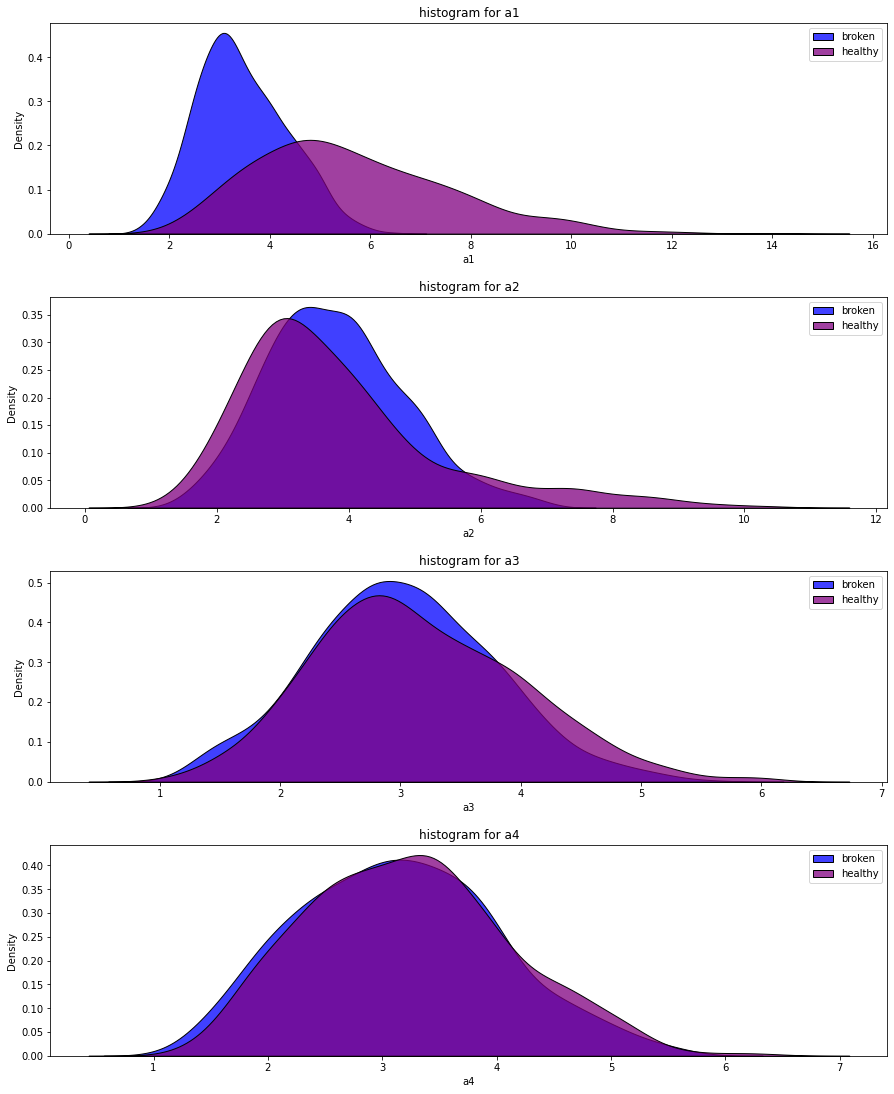

In [24]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

load = 0

plt.figure(figsize=(15,28*5))
plt.subplots_adjust(hspace = 0.3)
gs = gridspec.GridSpec(28, 1)
for i, val in enumerate(['a1','a2','a3','a4']):
    ax = plt.subplot(gs[i])
    sns.kdeplot(data = broken_stdev[load][val], color = "blue", multiple="stack")
    sns.kdeplot(data = healthy_stdev[load][val], color = "purple", multiple="stack")
    plt.legend(['broken', 'healthy'])
    ax.set_title('histogram for ' + str(val))
plt.show()

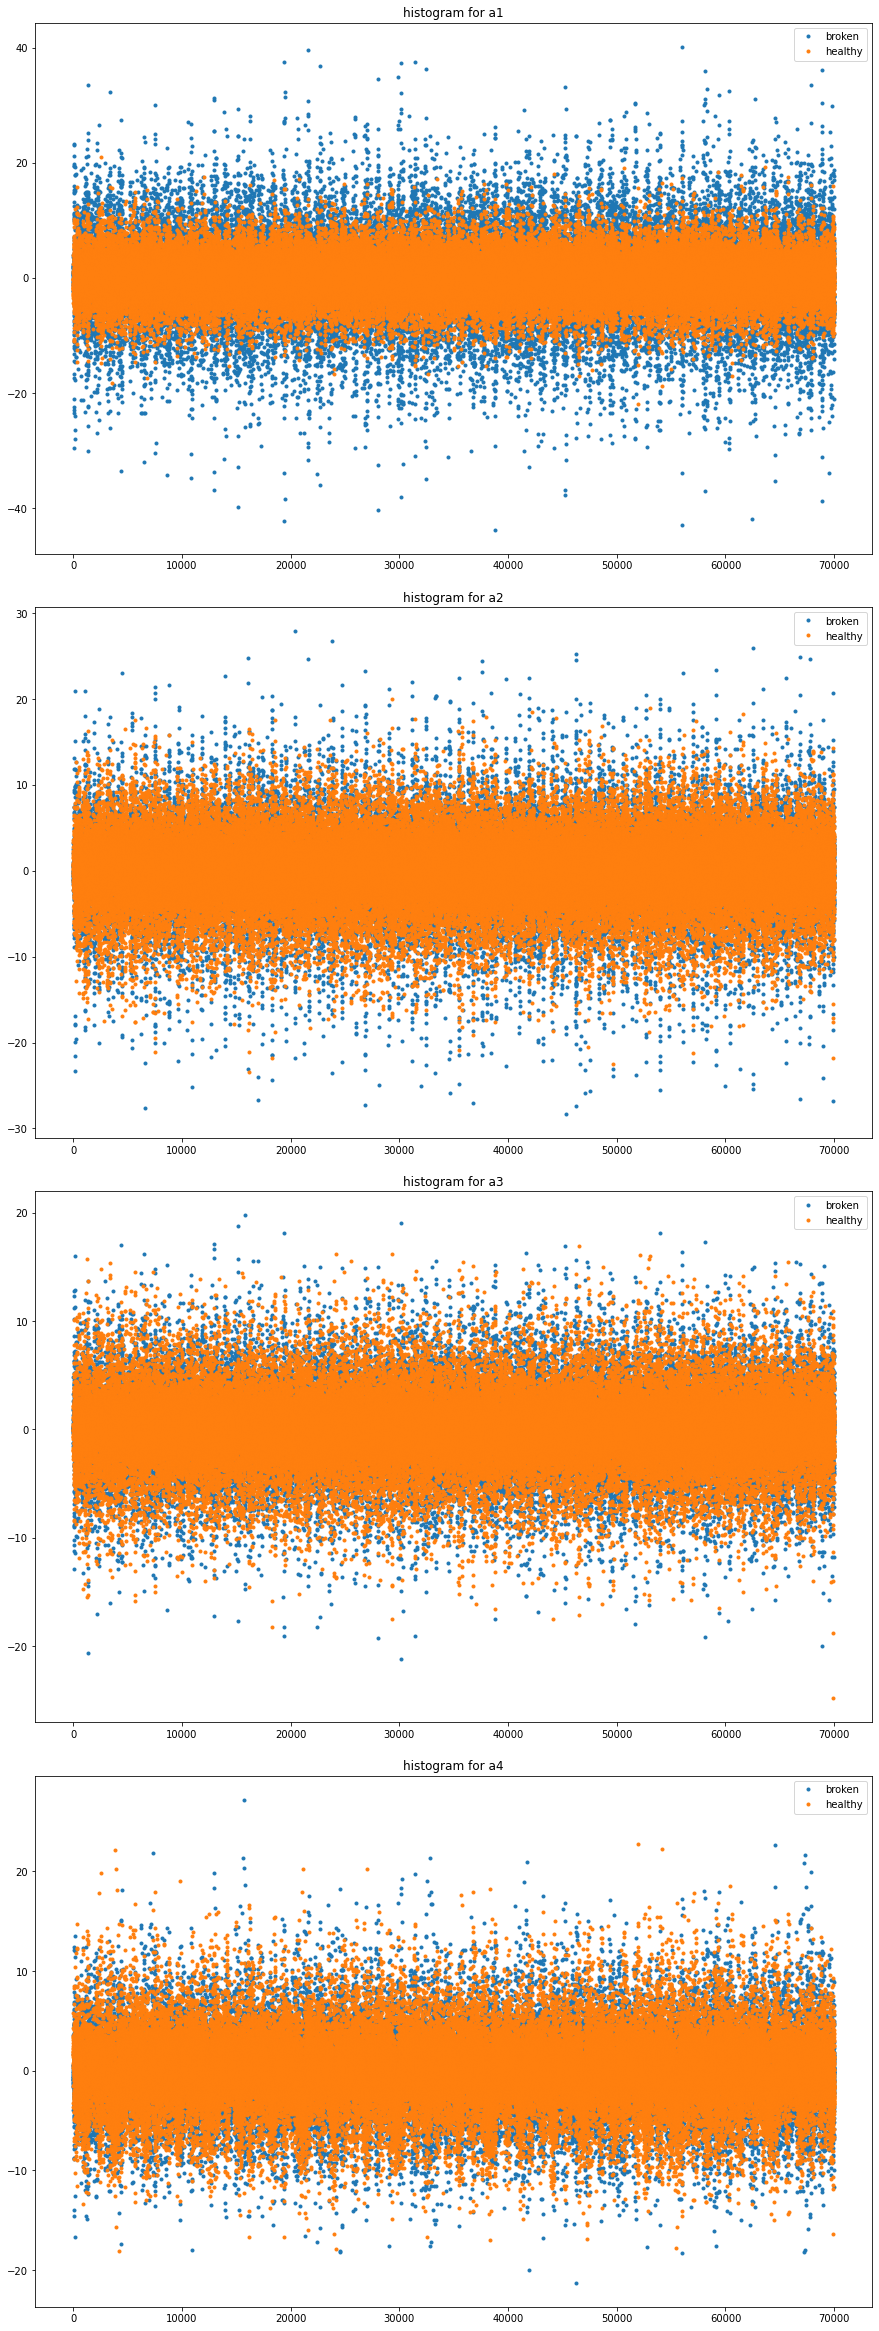

In [70]:
load = 1
plt.figure(figsize=(15,20*15))
plt.subplots_adjust(hspace = 0.1)
for i in range(0,4):
    ax = plt.subplot(gs[i])
    healthy[load].iloc[:70000, i].plot(style='.')
    broken[load].iloc[:70000, i].plot(style='.')
    plt.legend(['broken', 'healthy'])
    ax.set_title('histogram for a' + str(i+1))
plt.show()

<AxesSubplot:xlabel='a1', ylabel='Density'>

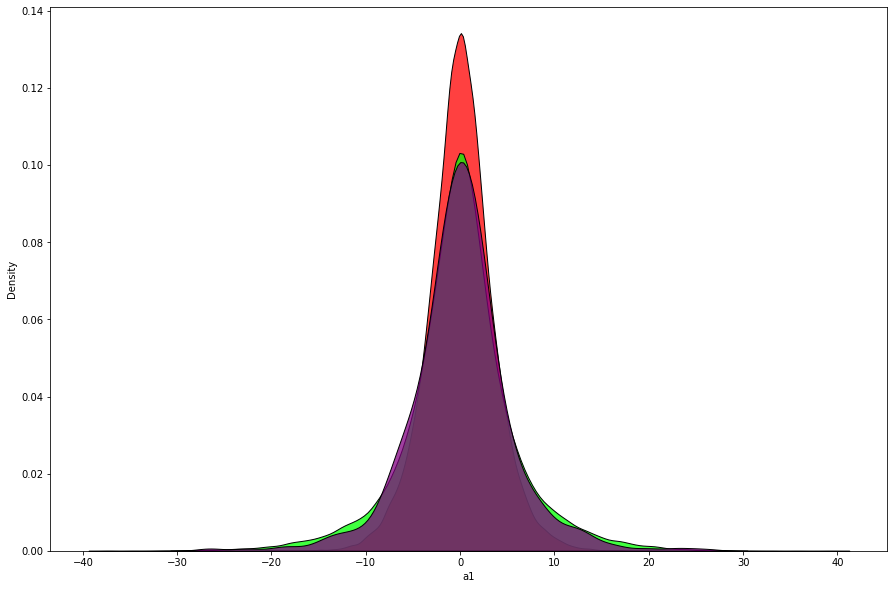

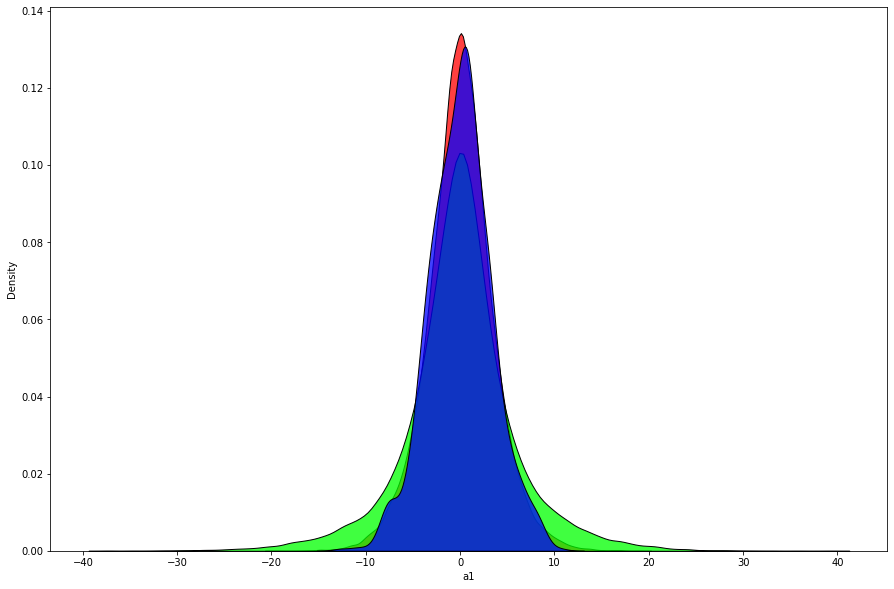

In [77]:
### DIVIDING THE DATASET FOR TRAINING, TESTING AND EVALUATION

import math

def segregate(df, load, fracs):
    total_size = len(df[load])
    train_frac = fracs[0]
    test_frac = fracs[1]
    eval_frac = fracs[2]

    training_set = df[load][['a1', 'load', 'gearbox_status']].iloc[:math.ceil(total_size * train_frac), :]
    testing_set = df[load][['a1', 'load', 'gearbox_status']].iloc[math.ceil(total_size * train_frac):math.ceil(total_size * (train_frac + test_frac)), :]
    eval_set = df[load][['a1', 'load', 'gearbox_status']].iloc[math.ceil(total_size * (train_frac + test_frac)):, :]
    
    return {
        'training': training_set,
        'testing': testing_set,
        'eval': eval_set
    }

def n(stdev, mean):
    return (1/(stdev * math.sqrt(2*math.pi)))*(math.e)**(-0.5*((-mean/stdev)**2))

# def ishealthy(x, tolerance):
#     h = segregate(healthy, load = 0, fracs = [0.6, 0.2, 0.2])['training']['a1']
#     return n(h.std(), h.mean())*(1 - tolerance) < n(x.std(), x.mean()) and n(x.std(), x.mean()) < n(h.std(), h.mean())*(1 + tolerance)

H = segregate(healthy, load = 0, fracs = [0.6, 0.2, 0.2])
B = segregate(broken, load = 0, fracs = [0.6, 0.2, 0.2])

h = H['training']['a1']
b = B['training']['a1']

# plt.figure(figsize=(15,2*5))

x = divide_into(H['testing'], 1000)
y = divide_into(B['testing'], 1000)

plt.figure(figsize=(15,2*5))
plt.subplots_adjust(hspace = 0.1)
sns.kdeplot(data = b, color="red", multiple="stack")
sns.kdeplot(data = h, color="lime", multiple="stack")
sns.kdeplot(data = x[0]['a1'], color="purple", multiple="stack")

plt.figure(figsize=(15,2*5))
plt.subplots_adjust(hspace = 0.1)
sns.kdeplot(data = b, color="red", multiple="stack")
sns.kdeplot(data = h, color="lime", multiple="stack")
sns.kdeplot(data = y[0]['a1'], color="blue", multiple="stack")

# print(pd.DataFrame(map(lambda el: ishealthy(el['a1'], 0.5), x)))
# print(ishealthy(x[0]['a1'], tolerance = 0.086))
# print(ishealthy(y, tolerance = 0.05))